### Эмбеддинги в NLP

В этом задании мы научимся работать с моделями для построения векторных представлений текста. Загрузим и потестируем предобученные модели, посмотрим, какие свойства и функции у них есть, обучим свою модель и с помощью нее улучшим качество кластеризации(и/или классификации) текстов.

Перед тем как приступать к выполнению задания не забудьте выполнить команду pip install -r <path_to_rep_requirements.txt> для того, чтобы в вашем виртуальном окружении были установлены правильные версии python пакетов.

In [1]:
import string
import warnings
import logging
import itertools

import nltk
import gensim
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import MiniBatchKMeans

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
%pylab inline

plt.style.use('default')
figsize(12, 9)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
 
font = {'family': 'Verdana',
        'weight': 'normal'}
mpl.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


Скачиваем rucorpora 15 с [диска](https://yadi.sk/d/fLRMFhm03Pbs98).
Либо выбираем предобученную модель с https://rusvectores.org/ru/models/. Выбор нужно обосновать.

In [4]:
path_to_ruscorpora = 'ruscorpora.model.bin'

#### Загрузим обученную на ruscorpora модель word2vec

In [5]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_ruscorpora,
    binary=True
)
model_word2vec.wv.vocab

2019-04-20 14:37:40,990 : INFO : loading projection weights from ruscorpora.model.bin
2019-04-20 14:37:40,995 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-20 14:37:51,483 : INFO : loaded (374526, 300) matrix from ruscorpora.model.bin


{'это': <gensim.models.keyedvectors.Vocab at 0x25169058780>,
 'весь': <gensim.models.keyedvectors.Vocab at 0x25169058898>,
 'человек': <gensim.models.keyedvectors.Vocab at 0x25169058668>,
 'мочь': <gensim.models.keyedvectors.Vocab at 0x25169058748>,
 'год': <gensim.models.keyedvectors.Vocab at 0x251690588d0>,
 'сказать': <gensim.models.keyedvectors.Vocab at 0x25169058860>,
 'время': <gensim.models.keyedvectors.Vocab at 0x25169058940>,
 'говорить': <gensim.models.keyedvectors.Vocab at 0x25169058978>,
 'становиться': <gensim.models.keyedvectors.Vocab at 0x251690589b0>,
 'знать': <gensim.models.keyedvectors.Vocab at 0x251690589e8>,
 'самый': <gensim.models.keyedvectors.Vocab at 0x25169058a20>,
 'жизнь': <gensim.models.keyedvectors.Vocab at 0x25169058a58>,
 'дело': <gensim.models.keyedvectors.Vocab at 0x25169058a90>,
 'день': <gensim.models.keyedvectors.Vocab at 0x25169058ac8>,
 'рука': <gensim.models.keyedvectors.Vocab at 0x25169058b00>,
 'первый': <gensim.models.keyedvectors.Vocab at 0x2

#### Посмотрим, как с ней обращаться

Можно посмотреть наиболее похожие на конкретное слово слова. Попробуйте свойства векторов word2vec: и подумайте какие слова нужно послать на вход, чтобы получить на выходе слова "школа",  "машинное", "обучение".

In [6]:
model_word2vec.most_similar(positive=['корабль'],
                            negative=['парус'],
                            topn=3)

2019-04-20 14:37:51,593 : INFO : precomputing L2-norms of word weight vectors


[('судно', 0.46701744198799133),
 ('крейсер', 0.3743194341659546),
 ('пароход', 0.33206048607826233)]

In [7]:
# получение слова "школа"

model_word2vec.most_similar(positive=['дети', 'здание', 'учительница', 'урок', 'класс'], negative=['мужчина'], topn=1)

[('школа', 0.5029754042625427)]

In [8]:
model_word2vec.most_similar(positive=['корабль', 'летать'],
                            negative=['плавать'],
                            topn=3)

[('самолет', 0.5802854299545288),
 ('судно', 0.5336376428604126),
 ('дирижабль', 0.5083059072494507)]

In [9]:
model_word2vec.most_similar(positive=['шахтер'],
                            negative=['грязь'],
                            topn=3)

[('горняк', 0.3543156385421753),
 ('ударник', 0.33688703179359436),
 ('металлург', 0.3220180869102478)]

In [10]:
model_word2vec.most_similar(positive=['учение', 'тьма'],
                            negative=['свет'],
                            topn=3)

[('мрак', 0.4193800687789917),
 ('догмат', 0.38442569971084595),
 ('философия', 0.3840946555137634)]

Еще есть функция, которая выводит лишнее слово в строке. Попробуйте придумать пример, с которым word2vec не справится.

In [11]:
model_word2vec.doesnt_match("коньяк компот водка пиво".split())

'компот'

Функция, которая выводит сходство между словами.  С ее помощью можно понимать значение слова нефть.

In [13]:
print(model_word2vec.similarity('нефть', 'газ'))
print(model_word2vec.similarity('нефть', 'вода'))
print(model_word2vec.similarity('нефть', 'водка'))
print(model_word2vec.similarity('нефть', 'духи'))
print(model_word2vec.similarity('нефть', 'компот'))

0.4017846
0.24677068
0.08598833
0.029723393
0.014373137


Или смотреть, где в России больше нефти.

In [14]:
print(model_word2vec.similarity('нефть', 'чечня'))
print(model_word2vec.similarity('нефть', 'якутск'))
print(model_word2vec.similarity('нефть', 'москва'))
print(model_word2vec.similarity('нефть', 'саратов'))
print(model_word2vec.similarity('нефть', 'сибирь'))

0.10231814
0.0374594
0.0076552005
0.0043799127
0.086305186


### Пункт 0
Допишите своих интересных примеров, характеризующих word2vec, попробуйте обосновать полученные результаты.

In [15]:
print(model_word2vec.similarity('лето', 'отпуск'))
print(model_word2vec.similarity('лето', 'работа'))
print(model_word2vec.similarity('зима', 'отпуск'))
print(model_word2vec.similarity('зима', 'работа'))

0.2631547
0.04377751
0.20519127
0.06228044


#### Теперь давайте обучим собственную модель
В качестве обучающего корпуса возьмем новости по 20 темам.

In [16]:
train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names, " - 20 возможных тем")

dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

dataset.data[0].split()

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']  - 20 возможных тем


['From:',
 'erik@cheshire.oxy.edu',
 '(Erik',
 'Adams)',
 'Subject:',
 'HELP!!',
 'My',
 'Macintosh',
 '"luggable"',
 'has',
 'lines',
 'on',
 'its',
 'screen!',
 'Organization:',
 'Occidental',
 'College,',
 'Los',
 'Angeles,',
 'CA',
 '90041',
 'USA.',
 'Distribution:',
 'comp',
 'Lines:',
 '20',
 'Okay,',
 'I',
 "don't",
 'use',
 'it',
 'very',
 'much,',
 'but',
 'I',
 'would',
 'like',
 'for',
 'it',
 'to',
 'keep',
 'working',
 'correctly,',
 'at',
 'least',
 'as',
 'long',
 'as',
 'Apple',
 'continues',
 'to',
 'make',
 'System',
 'software',
 'that',
 'will',
 'run',
 'on',
 'it,',
 'if',
 'slowly',
 ':-)',
 'Here',
 'is',
 'the',
 'problem:',
 'When',
 'the',
 'screen',
 'is',
 'tilted',
 'too',
 'far',
 'back,',
 'vertical',
 'lines',
 'appear',
 'on',
 'the',
 'screen.',
 'They',
 'are',
 'every',
 '10',
 'pixels',
 'or',
 'so,',
 'and',
 'seem',
 'to',
 'be',
 'affected',
 'somewhat',
 'by',
 'opening',
 'windows',
 'and',
 'pulling',
 'down',
 'menus.',
 'It',
 'looks',
 't

### Пункт 1

Предобработаем эти новости. Выкинем цифры, знаки пунктуации, переведем в нижний регистр, разобьем на слова.

Нормализуйте слова, например с помощью модуля nltk (или используйте любой другой способ на ваш выбор).

In [17]:
from nltk import word_tokenize # разбиваем на токены и удаляем ненужные знаки
from nltk.stem.snowball import SnowballStemmer # убираем окончания (приведение к корню)
stemmer = SnowballStemmer('english')
def normalize(raw_text):
    words = nltk.word_tokenize(raw_text)
    words = [word.lower() for word in words if word.isalpha()]
    preprocessed_text = [stemmer.stem(word) for word in words]
    return preprocessed_text

In [18]:
data_normalized = [normalize(news) for news in tqdm(dataset.data)]

100%|█████████████████████████████████████| 1777/1777 [00:10<00:00, 165.83it/s]


Теперь обучающий корпус готов.

In [19]:
sentences = data_normalized
model = gensim.models.Word2Vec(sentences, min_count=1)

2019-04-20 14:38:04,423 : INFO : collecting all words and their counts
2019-04-20 14:38:04,425 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-20 14:38:04,513 : INFO : collected 15447 word types from a corpus of 455137 raw words and 1777 sentences
2019-04-20 14:38:04,515 : INFO : Loading a fresh vocabulary
2019-04-20 14:38:04,556 : INFO : effective_min_count=1 retains 15447 unique words (100% of original 15447, drops 0)
2019-04-20 14:38:04,558 : INFO : effective_min_count=1 leaves 455137 word corpus (100% of original 455137, drops 0)
2019-04-20 14:38:04,605 : INFO : deleting the raw counts dictionary of 15447 items
2019-04-20 14:38:04,608 : INFO : sample=0.001 downsamples 50 most-common words
2019-04-20 14:38:04,609 : INFO : downsampling leaves estimated 352883 word corpus (77.5% of prior 455137)
2019-04-20 14:38:04,664 : INFO : estimated required memory for 15447 words and 100 dimensions: 20081100 bytes
2019-04-20 14:38:04,670 : INFO : resetting laye

2019-04-20 14:42:43,174 : INFO : EPOCH 2 - PROGRESS: at 87.84% examples, 2336 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:42:46,867 : INFO : EPOCH 2 - PROGRESS: at 89.76% examples, 2328 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:42:52,374 : INFO : EPOCH 2 - PROGRESS: at 94.77% examples, 2345 words/s, in_qsize 3, out_qsize 0
2019-04-20 14:42:55,678 : INFO : EPOCH 2 - PROGRESS: at 97.02% examples, 2341 words/s, in_qsize 2, out_qsize 1
2019-04-20 14:42:55,683 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-20 14:42:55,809 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-20 14:42:56,090 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-20 14:42:56,092 : INFO : EPOCH - 2 : training on 455137 raw words (353013 effective words) took 146.3s, 2412 effective words/s
2019-04-20 14:43:03,614 : INFO : EPOCH 3 - PROGRESS: at 1.97% examples, 774 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:43:04,915 : INFO : EPOCH 

2019-04-20 14:47:11,973 : INFO : EPOCH 4 - PROGRESS: at 72.76% examples, 2357 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:47:17,200 : INFO : EPOCH 4 - PROGRESS: at 75.58% examples, 2317 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:47:21,263 : INFO : EPOCH 4 - PROGRESS: at 80.98% examples, 2365 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:47:26,457 : INFO : EPOCH 4 - PROGRESS: at 83.40% examples, 2329 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:47:30,899 : INFO : EPOCH 4 - PROGRESS: at 87.84% examples, 2366 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:47:36,281 : INFO : EPOCH 4 - PROGRESS: at 90.38% examples, 2331 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:47:39,665 : INFO : EPOCH 4 - PROGRESS: at 94.77% examples, 2381 words/s, in_qsize 3, out_qsize 0
2019-04-20 14:47:44,451 : INFO : EPOCH 4 - PROGRESS: at 95.84% examples, 2329 words/s, in_qsize 2, out_qsize 1
2019-04-20 14:47:44,456 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-20 14:47:45,0

In [20]:
model = gensim.models.Word2Vec(iter=1)  # Инициализируем модель.
model.build_vocab(sentences)  # Строим словарь.
model.train(sentences, total_examples=model.corpus_count, epochs=20)  # Тренируем модель.

2019-04-20 14:50:06,323 : INFO : collecting all words and their counts
2019-04-20 14:50:06,325 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-20 14:50:06,406 : INFO : collected 15447 word types from a corpus of 455137 raw words and 1777 sentences
2019-04-20 14:50:06,408 : INFO : Loading a fresh vocabulary
2019-04-20 14:50:06,423 : INFO : effective_min_count=5 retains 5603 unique words (36% of original 15447, drops 9844)
2019-04-20 14:50:06,425 : INFO : effective_min_count=5 leaves 437596 word corpus (96% of original 455137, drops 17541)
2019-04-20 14:50:06,444 : INFO : deleting the raw counts dictionary of 15447 items
2019-04-20 14:50:06,446 : INFO : sample=0.001 downsamples 51 most-common words
2019-04-20 14:50:06,448 : INFO : downsampling leaves estimated 333283 word corpus (76.2% of prior 437596)
2019-04-20 14:50:06,470 : INFO : estimated required memory for 5603 words and 100 dimensions: 7283900 bytes
2019-04-20 14:50:06,473 : INFO : resetting la

2019-04-20 14:53:47,635 : INFO : EPOCH 2 - PROGRESS: at 67.87% examples, 2506 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:53:51,874 : INFO : EPOCH 2 - PROGRESS: at 72.76% examples, 2542 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:53:55,754 : INFO : EPOCH 2 - PROGRESS: at 75.58% examples, 2515 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:54:00,080 : INFO : EPOCH 2 - PROGRESS: at 80.98% examples, 2549 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:54:03,733 : INFO : EPOCH 2 - PROGRESS: at 83.40% examples, 2530 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:54:05,023 : INFO : EPOCH 2 - PROGRESS: at 85.42% examples, 2565 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:54:08,439 : INFO : EPOCH 2 - PROGRESS: at 87.84% examples, 2552 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:54:12,186 : INFO : EPOCH 2 - PROGRESS: at 90.38% examples, 2535 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:54:13,356 : INFO : EPOCH 2 - PROGRESS: at 92.29% examples, 2571 words/s, in_qsize 4, out_qsize 0
2

2019-04-20 14:58:06,476 : INFO : EPOCH 4 - PROGRESS: at 72.76% examples, 2533 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:58:10,568 : INFO : EPOCH 4 - PROGRESS: at 75.58% examples, 2502 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:58:14,525 : INFO : EPOCH 4 - PROGRESS: at 80.98% examples, 2544 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:58:18,964 : INFO : EPOCH 4 - PROGRESS: at 83.40% examples, 2508 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:58:22,821 : INFO : EPOCH 4 - PROGRESS: at 87.84% examples, 2549 words/s, in_qsize 6, out_qsize 0
2019-04-20 14:58:27,375 : INFO : EPOCH 4 - PROGRESS: at 89.76% examples, 2512 words/s, in_qsize 5, out_qsize 0
2019-04-20 14:58:30,691 : INFO : EPOCH 4 - PROGRESS: at 94.77% examples, 2562 words/s, in_qsize 3, out_qsize 0
2019-04-20 14:58:34,855 : INFO : EPOCH 4 - PROGRESS: at 95.84% examples, 2506 words/s, in_qsize 2, out_qsize 1
2019-04-20 14:58:34,859 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-20 14:58:35,2

2019-04-20 15:02:17,953 : INFO : EPOCH 6 - PROGRESS: at 69.95% examples, 2510 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:02:22,153 : INFO : EPOCH 6 - PROGRESS: at 72.76% examples, 2553 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:02:26,013 : INFO : EPOCH 6 - PROGRESS: at 75.58% examples, 2527 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:02:30,307 : INFO : EPOCH 6 - PROGRESS: at 80.98% examples, 2560 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:02:34,276 : INFO : EPOCH 6 - PROGRESS: at 83.40% examples, 2534 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:02:38,830 : INFO : EPOCH 6 - PROGRESS: at 87.84% examples, 2559 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:02:42,828 : INFO : EPOCH 6 - PROGRESS: at 90.38% examples, 2537 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:02:46,764 : INFO : EPOCH 6 - PROGRESS: at 94.77% examples, 2570 words/s, in_qsize 3, out_qsize 0
2019-04-20 15:02:50,962 : INFO : EPOCH 6 - PROGRESS: at 96.68% examples, 2541 words/s, in_qsize 2, out_qsize 1
2

2019-04-20 15:06:19,668 : INFO : EPOCH 8 - PROGRESS: at 63.42% examples, 2581 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:06:21,989 : INFO : EPOCH 8 - PROGRESS: at 64.21% examples, 2547 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:06:23,497 : INFO : EPOCH 8 - PROGRESS: at 64.83% examples, 2517 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:06:24,615 : INFO : EPOCH 8 - PROGRESS: at 66.52% examples, 2567 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:06:28,087 : INFO : EPOCH 8 - PROGRESS: at 67.53% examples, 2549 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:06:32,264 : INFO : EPOCH 8 - PROGRESS: at 67.87% examples, 2518 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:06:36,371 : INFO : EPOCH 8 - PROGRESS: at 72.76% examples, 2556 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:06:40,407 : INFO : EPOCH 8 - PROGRESS: at 75.58% examples, 2525 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:06:44,388 : INFO : EPOCH 8 - PROGRESS: at 80.98% examples, 2566 words/s, in_qsize 5, out_qsize 0
2

2019-04-20 15:10:31,726 : INFO : EPOCH 10 - PROGRESS: at 59.65% examples, 2496 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:10:33,231 : INFO : EPOCH 10 - PROGRESS: at 61.79% examples, 2530 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:10:36,689 : INFO : EPOCH 10 - PROGRESS: at 64.21% examples, 2544 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:10:38,171 : INFO : EPOCH 10 - PROGRESS: at 64.83% examples, 2515 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:10:39,716 : INFO : EPOCH 10 - PROGRESS: at 66.52% examples, 2552 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:10:42,529 : INFO : EPOCH 10 - PROGRESS: at 67.53% examples, 2554 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:10:47,075 : INFO : EPOCH 10 - PROGRESS: at 67.87% examples, 2513 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:10:50,431 : INFO : EPOCH 10 - PROGRESS: at 72.76% examples, 2571 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:10:55,309 : INFO : EPOCH 10 - PROGRESS: at 75.58% examples, 2518 words/s, in_qsize 6, out_

2019-04-20 15:14:38,991 : INFO : EPOCH 12 - PROGRESS: at 53.24% examples, 2474 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:14:41,153 : INFO : EPOCH 12 - PROGRESS: at 55.66% examples, 2495 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:14:47,565 : INFO : EPOCH 12 - PROGRESS: at 59.65% examples, 2479 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:14:49,530 : INFO : EPOCH 12 - PROGRESS: at 63.42% examples, 2583 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:14:51,896 : INFO : EPOCH 12 - PROGRESS: at 64.21% examples, 2546 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:14:53,380 : INFO : EPOCH 12 - PROGRESS: at 64.83% examples, 2518 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:14:55,574 : INFO : EPOCH 12 - PROGRESS: at 66.52% examples, 2536 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:14:57,992 : INFO : EPOCH 12 - PROGRESS: at 67.53% examples, 2549 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:15:02,448 : INFO : EPOCH 12 - PROGRESS: at 67.87% examples, 2511 words/s, in_qsize 5, out_

2019-04-20 15:18:36,546 : INFO : EPOCH 14 - PROGRESS: at 39.34% examples, 2440 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:18:38,914 : INFO : EPOCH 14 - PROGRESS: at 41.25% examples, 2458 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:18:44,726 : INFO : EPOCH 14 - PROGRESS: at 45.92% examples, 2462 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:18:47,103 : INFO : EPOCH 14 - PROGRESS: at 48.17% examples, 2479 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:18:53,235 : INFO : EPOCH 14 - PROGRESS: at 53.24% examples, 2469 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:18:55,239 : INFO : EPOCH 14 - PROGRESS: at 55.66% examples, 2495 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:19:01,794 : INFO : EPOCH 14 - PROGRESS: at 59.65% examples, 2474 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:19:03,524 : INFO : EPOCH 14 - PROGRESS: at 63.42% examples, 2585 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:19:05,983 : INFO : EPOCH 14 - PROGRESS: at 64.21% examples, 2546 words/s, in_qsize 5, out_

2019-04-20 15:22:21,057 : INFO : EPOCH 16 - PROGRESS: at 15.64% examples, 2258 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:22:26,369 : INFO : EPOCH 16 - PROGRESS: at 19.92% examples, 2302 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:22:29,309 : INFO : EPOCH 16 - PROGRESS: at 21.95% examples, 2307 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:22:34,795 : INFO : EPOCH 16 - PROGRESS: at 26.11% examples, 2354 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:22:37,529 : INFO : EPOCH 16 - PROGRESS: at 28.59% examples, 2373 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:22:42,997 : INFO : EPOCH 16 - PROGRESS: at 33.65% examples, 2406 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:22:45,831 : INFO : EPOCH 16 - PROGRESS: at 35.57% examples, 2416 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:22:50,810 : INFO : EPOCH 16 - PROGRESS: at 39.34% examples, 2453 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:22:54,056 : INFO : EPOCH 16 - PROGRESS: at 41.25% examples, 2434 words/s, in_qsize 5, out_

2019-04-20 15:26:35,561 : INFO : EPOCH 18 - PROGRESS: at 15.64% examples, 2259 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:26:40,625 : INFO : EPOCH 18 - PROGRESS: at 19.92% examples, 2332 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:26:43,719 : INFO : EPOCH 18 - PROGRESS: at 21.50% examples, 2329 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:26:48,798 : INFO : EPOCH 18 - PROGRESS: at 26.11% examples, 2391 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:26:52,150 : INFO : EPOCH 18 - PROGRESS: at 28.76% examples, 2374 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:26:56,923 : INFO : EPOCH 18 - PROGRESS: at 33.65% examples, 2442 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:27:00,425 : INFO : EPOCH 18 - PROGRESS: at 35.45% examples, 2411 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:27:04,939 : INFO : EPOCH 18 - PROGRESS: at 39.34% examples, 2473 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:27:08,418 : INFO : EPOCH 18 - PROGRESS: at 41.25% examples, 2443 words/s, in_qsize 6, out_

2019-04-20 15:30:31,874 : INFO : EPOCH 20 - PROGRESS: at 1.97% examples, 868 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:30:33,384 : INFO : EPOCH 20 - PROGRESS: at 3.26% examples, 1576 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:30:39,329 : INFO : EPOCH 20 - PROGRESS: at 8.10% examples, 1878 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:30:41,641 : INFO : EPOCH 20 - PROGRESS: at 9.40% examples, 2044 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:30:47,543 : INFO : EPOCH 20 - PROGRESS: at 13.45% examples, 2152 words/s, in_qsize 5, out_qsize 0
2019-04-20 15:30:49,785 : INFO : EPOCH 20 - PROGRESS: at 15.64% examples, 2241 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:30:54,702 : INFO : EPOCH 20 - PROGRESS: at 19.92% examples, 2326 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:30:57,905 : INFO : EPOCH 20 - PROGRESS: at 21.50% examples, 2315 words/s, in_qsize 6, out_qsize 0
2019-04-20 15:31:03,015 : INFO : EPOCH 20 - PROGRESS: at 26.11% examples, 2381 words/s, in_qsize 5, out_qsize

(6666967, 9102740)

Нарисуем слова из первой новости в новом векторном пространстве.

In [21]:
# Берем слова из первой новости, достаем соостветствующие векторы,
# выбрасываем слова, для которых векторов нет. 
# Подумайте - как так могло получится, что нет векторов?
labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model[x])
        labels.append(x)
    except KeyError:
        continue

In [22]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(8, 8))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

### Пункт 2
Переведите многомерные векторы в двумерные (можно использовать TSNE, PCA, другие методы сокращения размерности), выберите часть слов для отрисовки. Как параметры и методы отрисовки влияют на полученный график? Как это можно обьяснить?

In [23]:
# для понижения размерности воспользуемся TSNE

from sklearn.manifold import TSNE
def embeddings_2d(embeddings):
    tsne = TSNE(n_components = 2, random_state = 18)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

In [24]:
num_words_to_draw = 50
low_dim_vectors = embeddings_2d(embeddings)

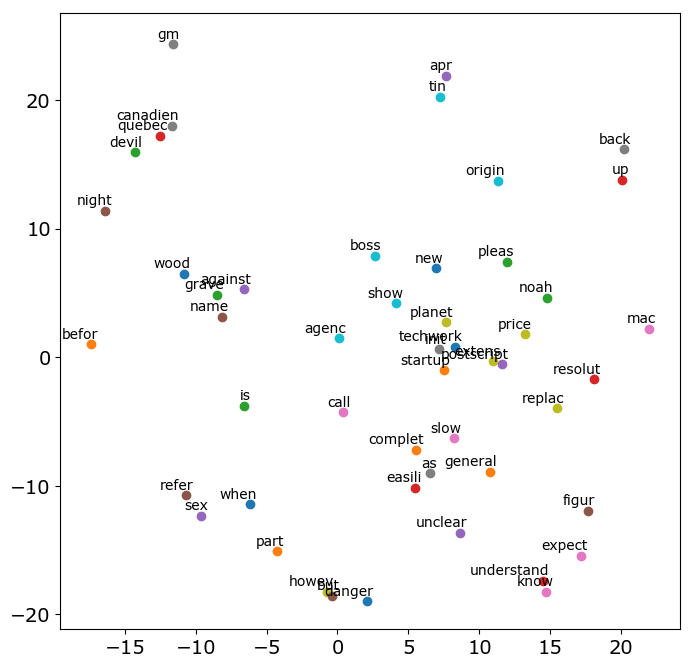

In [25]:
# Рисуем только первые 50 слов
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

### Пункт 3
Проделайте аналогичную отрисовку и сжатие векторов для предобученной модели (для этого скачайте бинарник по этой [ссылке](https://code.google.com/archive/p/word2vec/) (файл GoogleNews-vectors-negative300) по аналогии с тем, как мы работали с русским корпусом. Сравните результаты.

In [26]:
path_to_googlecorp = 'GoogleNews-vectors-negative300.bin.gz'

In [27]:
model_word2vec_google = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_googlecorp,
    binary=True
)
model_word2vec_google.wv.vocab

2019-04-20 15:32:41,345 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2019-04-20 15:32:41,347 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-20 15:35:07,156 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


{'</s>': <gensim.models.keyedvectors.Vocab at 0x25121cdef60>,
 'in': <gensim.models.keyedvectors.Vocab at 0x25121db1c18>,
 'for': <gensim.models.keyedvectors.Vocab at 0x25121db1908>,
 'that': <gensim.models.keyedvectors.Vocab at 0x25121db1cf8>,
 'is': <gensim.models.keyedvectors.Vocab at 0x25121db1d30>,
 'on': <gensim.models.keyedvectors.Vocab at 0x25121db1940>,
 '##': <gensim.models.keyedvectors.Vocab at 0x25121db15f8>,
 'The': <gensim.models.keyedvectors.Vocab at 0x25121cc7a58>,
 'with': <gensim.models.keyedvectors.Vocab at 0x25121d917f0>,
 'said': <gensim.models.keyedvectors.Vocab at 0x25121d91128>,
 'was': <gensim.models.keyedvectors.Vocab at 0x25121d91320>,
 'the': <gensim.models.keyedvectors.Vocab at 0x25121d914e0>,
 'at': <gensim.models.keyedvectors.Vocab at 0x25121d91ba8>,
 'not': <gensim.models.keyedvectors.Vocab at 0x25121d91eb8>,
 'as': <gensim.models.keyedvectors.Vocab at 0x25121d91f60>,
 'it': <gensim.models.keyedvectors.Vocab at 0x25121d91550>,
 'be': <gensim.models.keyed

In [28]:
labels_google = []
embeddings_google = []
data_to_tsne_google = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne_google)):
    try:
        embeddings_google.append(model_word2vec_google[x])
        labels_google.append(x)
    except KeyError:
        continue
low_dim_vectors_google = embeddings_2d(embeddings_google)

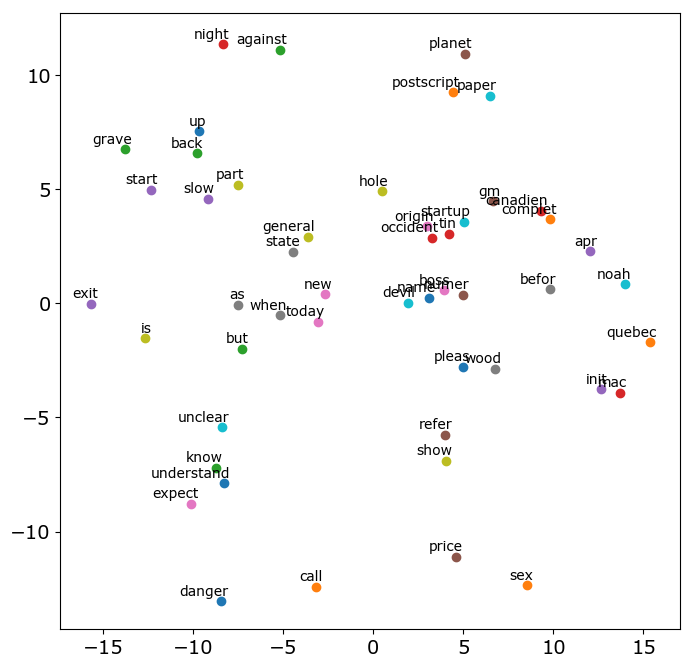

In [29]:
# Рисуем только первые 50 слов - теперь можем визуально сравнить с обученной моделью
labels_to_draw_google = [labels_google[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors_google, labels_to_draw_google)

### Попробуем с помощью нашей модели улучшить качество кластеризации текстов
Если вы не знаете, что такое кластеризация - почитать об этом можно по [ссылке](http://scikit-learn.org/stable/modules/clustering.html).

Если вам все равно кажется, что это сложно, и вы чувствуете себя более уверено в задаче классификации - вместо задачи кластеризации можно рассматривать задачу классификации - тогда вместо функции quality используйте roc-auc из библиотеки scikit-learn, все остальные шаги предобработки и измерения признаков аналогичны.

Измерять качество кластеризации будем следующим образом - измерим количество правильных попаданий категории в кластеры.

In [30]:
def quality(preds, target):
    permutations = list(itertools.permutations([0, 1, 2]))
    scores = []
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        scores.append(float(sum(mapped_preds != target)) / len(target))
    return 1 - min(scores)

### Пункт 4
Кластеризуйте датасет с заданием признаков с помощью one hot encoding - посмотрите на результат.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x: x, min_df=1).fit(data_normalized)
Xencoded=vectorizer.transform(data_normalized).astype(bool)
tsne = TSNE(n_components = 3, random_state = 18)
low_dim_vectors = tsne.fit_transform(Xencoded.toarray())
preds = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.5644344400675295

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x: x, min_df=1).fit(data_normalized)
Xencoded=vectorizer.transform(data_normalized)
tsne = TSNE(n_components = 3, random_state = 18)
low_dim_vectors = tsne.fit_transform(Xencoded.toarray())
preds = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.48902644907146875

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=1).fit(data_normalized)
Xencoded=vectorizer.transform(data_normalized)
tsne = TSNE(n_components = 3, random_state = 18)
low_dim_vectors = tsne.fit_transform(Xencoded.toarray())
preds = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.7028700056274619

### Пункт 5
Далее кластеризуем тексты на векторах, полученных из модели, которую мы сами обучили.

Напишем функцию, которая делает из предложения вектор - усредняет векторы всех слов в этом предложении. Если слова нет в словаре, то вместо вектора этого слова используется нулевой вектор.

In [34]:
def average_feature_vector(words, model):
    len_vec = len((model[model.wv.vocab])[0])
    average_feature_vector = np.zeros((len_vec), dtype="float32")    
    featureVec = np.zeros((len_vec), dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.vocab)

    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            try:
                featureVec = np.add(featureVec, model[word])
            except:
                featureVec = np.add(featureVec, np.zeros((len_vec), dtype="float32"))
                pass

    featureVec = np.divide(featureVec, nwords)
    return featureVec

Применим функцию к нашим данным (уже нормализованным функцией normalize).

In [35]:
data_normalized_vectors = [average_feature_vector(sent, model)
                           for sent in data_normalized]

Сожмем массив признаков с помощью TSNE до нескольких компонент (попробуйте поварьировать число компонент).

In [36]:
tsne = TSNE(n_components = 3, random_state = 18)
low_dim_vectors = tsne.fit_transform(data_normalized_vectors)

Примените алгоритм кластеризации (например, K-means).

In [37]:
preds = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.9656724817107485

### Пункт 6

Кластеризуйте тексты на векторах, полученных из предобученной модели. Какой результат получился лучше? Почему?

In [38]:
data_normalized_vectors_google = [average_feature_vector(sent, model_word2vec_google)
                           for sent in data_normalized]
low_dim_vectors_google = tsne.fit_transform(data_normalized_vectors_google)
preds_google = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors_google)
quality(preds_google, dataset.target)

0.9369724254361284

In [39]:
data_normalized_vectors_pre = [average_feature_vector(sent, model_word2vec)
                           for sent in data_normalized]
low_dim_vectors_pre = tsne.fit_transform(data_normalized_vectors_pre)
preds_pre = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors_pre)
quality(preds_pre, dataset.target)

0.6510973550928532

### Пункт 7

Попробуйте получить аналогичные векторы и провести исследование на них с помощью fastq - [неплохое введение](https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/).

In [51]:
from gensim.models.wrappers import FastText

In [66]:
model_fasttext = gensim.models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

2019-04-21 00:24:40,318 : INFO : loading projection weights from wiki-news-300d-1M.vec
2019-04-21 00:24:40,320 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-21 00:29:14,043 : INFO : loaded (999994, 300) matrix from wiki-news-300d-1M.vec


In [71]:
# кластеризуем по аналогии
data_normalized_vectors_fasttext = [average_feature_vector(sent, model_fasttext)
                           for sent in data_normalized]

In [73]:
tsne = TSNE(n_components = 2, random_state = 18)
low_dim_vectors_fasttext = tsne.fit_transform(data_normalized_vectors_fasttext)
preds_fasttext = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors_fasttext)
quality(preds_fasttext, dataset.target)

0.9667979741136747

#### Попробуем объединить вектора трех лучших моделей - обученной, word2vec от google и fastText и сделать кластеризацию на них

In [84]:
# для всех трех моделей взяли TSNE с 2 компонентами, так как это дает бОльшую точность

# также проверяли гипотезу об улучшении точности без слов дубликатов - точность всех моделей выросла (для fastText строчкой выше удаление дубликатов уже сделано)

data_normalized = [list(set(sent)) for sent in data_normalized]

low_dim_vectors_google = tsne.fit_transform(data_normalized_vectors_google)
preds_google = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors_google)
print(quality(preds_google, dataset.target))

low_dim_vectors = tsne.fit_transform(data_normalized_vectors)
preds = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors)
print(quality(preds, dataset.target))

0.963984243106359
0.9707371975239167


In [85]:
# соединяем вектора

vectors_conc1 = np.concatenate((low_dim_vectors_fasttext, low_dim_vectors_google), axis = 1)
vectors_conc = np.concatenate((vectors_conc1, low_dim_vectors), axis = 1)

In [86]:
preds_conc = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(vectors_conc)
quality(preds_conc, dataset.target)

0.9729881823297692

In [69]:
# преобразуем и нарисуем первые 50 слов с помощью fasttext также, как с другими моделями

labels_fasttext = []
embeddings_fasttext = []
data_to_tsne_fasttext = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne_fasttext)):
    try:
        embeddings_fasttext.append(model_fasttext[x])
        labels_fasttext.append(x)
    except KeyError:
        continue
low_dim_vectors_fasttext = embeddings_2d(embeddings_fasttext)

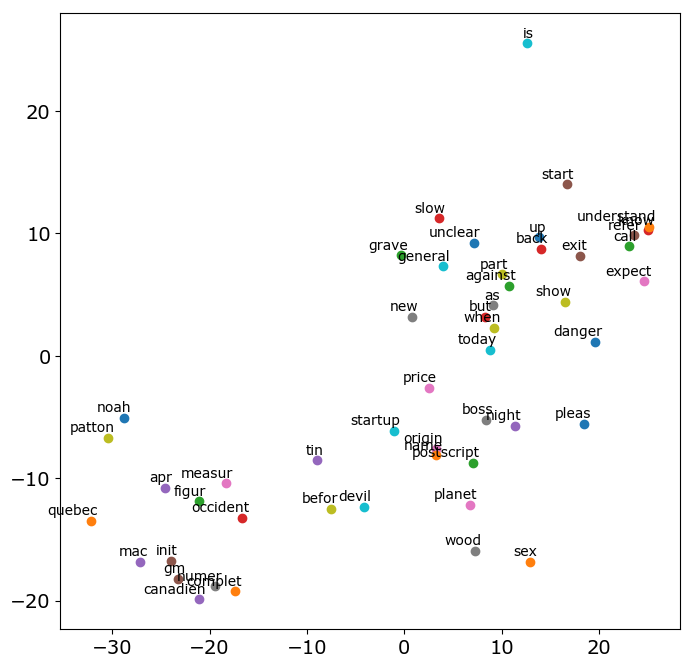

In [70]:
labels_to_draw_fasttext = [labels_fasttext[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors_fasttext, labels_to_draw_fasttext)

### Пункт 8
С помощью библиотеки pytorch-pretrained-bert попробуйте получить векторы для ваших текстов ([инструкция](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/extract_features.py)) и провести исследование.

In [53]:
# так как pytorch-pretrained-bert не удалось установить, используем bert_embedding

from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding(model='bert_24_1024_16', dataset_name='book_corpus_wiki_en_cased')

In [55]:
# склеиваем документы из токенов обратно (bert сам делает разбиение на токены)
# используем сразу очищенные от знаков препинания, чисел и окончаний тексты

full_sent = [' '.join(sent).lower() for sent in data_normalized]

In [56]:
full_sent[0]

'run correct occident help vertic luggabl ca as problem screen there when but from okay too new softwar to is note organ veri keep appear back open for make somewhat erik have feel use do manual usa at comp involv long shop tilt system my pixel colleg window everi here distribut adam one connector a be doe least continu on buy comput much larri am menus that line relat like they would connect los far strong and monitor enough affect if the or pull servic down are macintosh has angel work subject i person what suggest so book look also sure pina about slowli appl by take this will seem between loos rest it of not'

In [57]:
# для каждого документа появляется набор векторов для слов в документе

data_normalized_vectors_bert = bert_embedding(full_sent, 'avg')

In [61]:
# усредняем векторы слов внутри каждого документа

data_vectors_for_sentences_bert = [np.mean(sent[1], axis = 0) for sent in data_normalized_vectors_bert]

In [62]:
# понижаем размерность

tsne = TSNE(n_components = 3, random_state = 18)
low_dim_vectors_bert = tsne.fit_transform(data_vectors_for_sentences_bert)

In [63]:
# кластеризуем и смотрим качество

preds_bert = MiniBatchKMeans(n_clusters=3, random_state = 42).fit_predict(low_dim_vectors_bert)
quality(preds_bert, dataset.target)

0.4879009566685425